# Regridding WRF-BCC

In [1]:
import pandas as pd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline

### Loading Data

In [2]:
#load wrf-bcc dataset
#find all csv files for each variable and sort
files_refc = glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_REFC*')
files_var = glob.glob(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_UVV*')
files_refc.sort()
files_var.sort()

#concat all dataframes of same variable type together
df_refc = pd.concat(map(pd.read_csv, files_refc), ignore_index=True)
df_var = pd.concat(map(pd.read_csv, files_var), ignore_index=True)

#combine the new dataframes together
df = pd.concat([df_var, df_refc])

#get rid of the duplicates
df = df.drop_duplicates(subset=['x','y','Time'])
df

,Unnamed: 0,x,y,Time,UH,DBZ,UVV
0,0,1137,68,1990-10-01T15:00:00.000000000,4.314072,50.534767,18.529408
1,1,1138,68,1990-10-01T16:00:00.000000000,11.310173,0.000000,21.767344
2,2,1138,69,1990-10-01T16:00:00.000000000,1.708199,0.000000,19.898508
3,3,1135,70,1990-10-01T16:00:00.000000000,2.226369,0.000000,18.301819
4,4,1136,70,1990-10-01T16:00:00.000000000,1.438110,0.000000,19.420233
...,...,...,...,...,...,...,...
50369937,3014602,909,700,2005-09-30T00:00:00.000000000,0.241252,40.251040,1.671814
50369938,3014603,908,701,2005-09-30T00:00:00.000000000,0.003803,40.213430,1.964281
50369939,3014604,919,701,2005-09-30T00:00:00.000000000,0.113389,40.785255,2.138664
50369940,3014605,920,702,2005-09-30T00:00:00.000000000,0.123360,40.707443,3.051859


In [3]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

### Data Conversion

In [4]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog1 = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog1.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds, geog

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

new_copy, geog = Data_Conv(ds)

In [6]:
#threshold the files
df_new = df[((df['DBZ'] >= 40.0) & (df['UVV'] >= 18.0))]
print(f'amount of rows removed from dataframe: {len(df) - len(df_new)}')

amount of rows removed from dataframe: 51812642


In [7]:
lats = []
lons = []

#iterate through each row of the dataframe to and add one for each instance 
for rid, row in df_new.iterrows():
    
    #find closest lat/long from the coarsened array to the dataframe.
    #NOTE: must flatten the array into 1 dim to work properly
    lats.append(find_nearest(new_copy.lat.values.flatten(), geog.CLAT.values[0,row.y,row.x]))
    lons.append(find_nearest(new_copy.lon.values.flatten(), geog.CLONG.values[0,row.y,row.x]))

#append the lat/long values
df_new['coarse_lat'] = lats
df_new['coarse_lon'] = lons

/tmp/ipykernel_18368/826128256.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['coarse_lat'] = lats
/tmp/ipykernel_18368/826128256.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['coarse_lon'] = lons


In [8]:
#save off the regridded file 
df_new.to_csv(f'/home/scratch/jcorner1/syn_sev/dataframes/HIST_UVV_REFC_regrid_threshold_dataframe.csv')

In [15]:
zeros = np.zeros((899,1399))

#iterate through
for rid, row in df_new.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
zeros[zeros == 0.0] = np.nan

ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

ds_cor, geog = Data_Conv(ds)

### Plotting Data

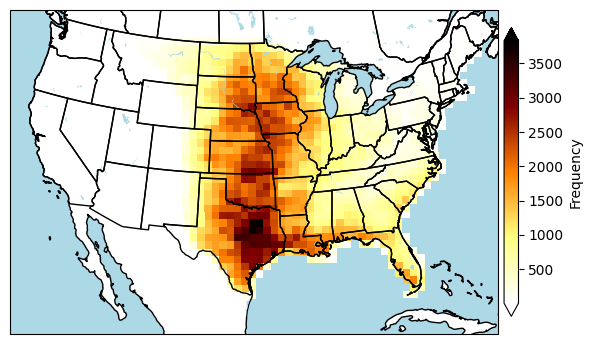

In [18]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 500)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)